In [ ]:
# default_exp actorcritic.dads

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
#export
import torch.nn.utils as nn_utils
from fastai.torch_basics import *
import torch.nn.functional as F
from fastai.data.all import *
from fastai.basics import *
from dataclasses import field,asdict
from typing import List,Any,Dict,Callable
from collections import deque
import gym
import torch.multiprocessing as mp
from torch.optim import *
from dataclasses import dataclass

from fastrl.data import *
from fastrl.async_data import *
from fastrl.basic_agents import *
from fastrl.learner import *
from fastrl.metrics import *
from fastai.callback.progress import *
from fastrl.ptan_extension import *
from fastrl.actorcritic.sac import *
from fastrl.actorcritic.diayn import *
import gym
from torch.distributions import *

import matplotlib.pyplot as plt

if IN_NOTEBOOK:
    from IPython import display
    import PIL.Image

/opt/conda/envs/fastrl/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
# hide
import matplotlib.pyplot as plt

from nbdev.showdoc import *
from nbdev.imports import *
from nbdev.export2html import *
if not os.environ.get("IN_TEST", None):
    assert IN_NOTEBOOK
    assert not IN_COLAB
    assert IN_IPYTHON

# DADS

> Dynamics-Aware Unsupervised Discovery of Skills

> Warning: This is a partial-working version of DADS, HOWEVER a full implimentation will require a meta learner to be env agnostic. This is due to the planner needing to 
    know whether certain predicted states are more valuable than others so that it can select the right skill. Their implimenation uses GoalEnvs as opposed 
to regular envs which, is not very portable. I think after the refactor, I will use a DQN for DIAYN and DADS instead. 
I can have it so that if a goal env IS in fact being used, then it can ignore the meta learner and use the compute reward directly.

## GMM
> A neural net with a gaussian probability distribution component.

Gaussian Mixture Models parameterized by neural nets can be used for:
- Giving the probability that a given `state` + `action` will result in `next_state`
- Predict what the `next_state` will look like given a `state` + `action`

Hopefully from the list above, it is understandable *why* a GMM can be useful.
Since it has a probabilistic component, you can avoid instances of (easily) overfitting. 

In [ ]:
# export 
class OptionalClampLinear(Module):
    def __init__(self,num_inputs,state_dims,fix_variance:bool=False,
                 clip_min=0.3,clip_max=10.0):
        "Linear layer or constant block used for std."
        store_attr()
        if not self.fix_variance: self.fc=nn.Linear(self.num_inputs,self.state_dims)
    
    def forward(self,x):
        if self.fix_variance: return torch.full((x.shape[0],self.state_dims),1.0)
        else:                 return torch.clamp(nn.Softplus()(self.fc(x)),self.clip_min,self.clip_max)

class MultiCompGMM(Module):
    def __init__(self,num_inputs,state_dims,n_components,fix_variance:bool=False):
        "Multi-component GMM parameterized by a fully connected layer with optional std layer."
        store_attr()
        self.logit_fc=nn.Linear(self.num_inputs,self.n_components)
        self.mean_fcs=nn.ModuleList([nn.Linear(self.num_inputs,self.state_dims) 
                                     for _ in range(self.n_components)])
        self.std_fcs=nn.ModuleList([OptionalClampLinear(self.num_inputs,self.state_dims,fix_variance) 
                                    for _ in range(self.n_components)])
        self.means,self.logits,self.stds=[],[],[]
    
    def forward(self,x):
        self.means=torch.stack([o(x) for o in self.mean_fcs],dim=1)
        self.stds=torch.stack([o(x) for o in self.std_fcs],dim=1)
        self.logits=self.logit_fc(x)
        return MixtureSameFamily(
            mixture_distribution=Categorical(self.logits),
            component_distribution=Independent(Normal(self.means,self.stds),1)
        )
    
class SimpleGMM(Module):
    def __init__(self,num_inputs,state_dims,fix_variance:bool=False):
        "Single-component GMM parameterized by a fully connected layer with optional std layer."
        store_attr()
        self.mean_fc=nn.Linear(self.num_inputs,self.state_dims)
        self.std_fc=OptionalClampLinear(self.num_inputs,self.state_dims,fix_variance)
        
    def forward(self,x): return Independent(Normal(self.mean_fc(x),self.std_fc(x)),1)

class GMM(Module):
    def __init__(self,num_inputs,state_dims,n_components,fix_variance:bool=False):
        "N-component GMM parameterized by fully connected layers with optional std layers."
        store_attr()
        if self.n_components>1: self.distribution=MultiCompGMM(num_inputs,state_dims,n_components,fix_variance)
        else:                   self.distribution=SimpleGMM(num_inputs,state_dims,fix_variance)
        
    def forward(self,x): return self.distribution(x)

The GMM is going to try to predict the next state. So lets make a simple input to optimize against.
This test will be of a hot airballoon. Lets see if we can have a reasonable next state prediction.

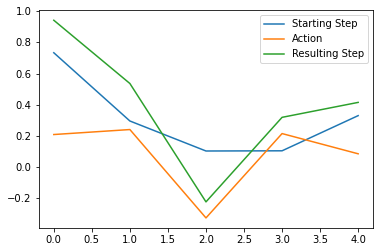

In [ ]:
hot_air_ballon_start_states=torch.rand((5,1))
hot_air_ballon_start_actions=torch.rand((5,1))-0.5
hot_air_ballon_next_states=hot_air_ballon_start_states+hot_air_ballon_start_actions

plt.plot(hot_air_ballon_start_states.numpy(),label='Starting Step')
plt.plot(hot_air_ballon_start_actions.numpy(),label='Action')
plt.plot(hot_air_ballon_next_states.numpy(),label='Resulting Step')
plt.legend()
plt.show()

In [ ]:
gmm=GMM(2,1,2,fix_variance=False)
opt=Adam(gmm.parameters(),lr=3e-4)

First, lets see if the GMM can predict the next state accurately...

In [ ]:
x=torch.hstack([hot_air_ballon_start_states,hot_air_ballon_start_actions])
dist=gmm(x)
hot_air_ballon_start_states+dist.mean

tensor([[ 0.5577],
        [ 1.6318],
        [-0.7048],
        [ 0.0216],
        [-0.0761]], grad_fn=<AddBackward0>)

In [ ]:
hot_air_ballon_next_states

tensor([[ 0.9418],
        [ 0.5359],
        [-0.2236],
        [ 0.3188],
        [ 0.4147]])

Yeah the GMM is way off...
So lets first see if we can get it to optimize to predict a next state...

In [ ]:
next_timesteps=hot_air_ballon_next_states-hot_air_ballon_start_states    
x=torch.hstack([hot_air_ballon_start_states,hot_air_ballon_start_actions])

for step in range(5000):
    dist=gmm(x)

    opt.zero_grad()
    loss=-torch.mean(dist.log_prob(next_timesteps))
    loss.backward()
    if step%1000==0:print(loss,torch.mean(dist.log_prob(next_timesteps)))
    opt.step()

tensor(0.6004, grad_fn=<NegBackward>) tensor(-0.6004, grad_fn=<MeanBackward0>)
tensor(0.1176, grad_fn=<NegBackward>) tensor(-0.1176, grad_fn=<MeanBackward0>)
tensor(-0.2016, grad_fn=<NegBackward>) tensor(0.2016, grad_fn=<MeanBackward0>)
tensor(-0.2783, grad_fn=<NegBackward>) tensor(0.2783, grad_fn=<MeanBackward0>)
tensor(-0.2847, grad_fn=<NegBackward>) tensor(0.2847, grad_fn=<MeanBackward0>)


In [ ]:
x=torch.hstack([hot_air_ballon_start_states,hot_air_ballon_start_actions])
dist=gmm(x)
hot_air_ballon_start_states+dist.mean

tensor([[ 0.9408],
        [ 2.9151],
        [-0.5615],
        [ 0.5469],
        [ 0.4190]], grad_fn=<AddBackward0>)

In [ ]:
hot_air_ballon_next_states

tensor([[ 0.9418],
        [ 0.5359],
        [-0.2236],
        [ 0.3188],
        [ 0.4147]])

This is much better, the GMM is making a better prediction of what the next state is going to be...

## Skill Dynamics
> Now that we have a working GMM, we need a way to modify our input data to be useful for the DADS agent.

In [ ]:
# export
class SkillDynamics(Module):
    def __init__(self,s_dim,a_dim,n_components,fix_variance:bool=False,
                 use_model_mean:bool=None,use_batch_norm:bool=True,fc_params:tuple=None):
        store_attr(but='fc_params,use_model_mean')
        self.fc_params=ifnone(fc_params,(256,256))
        self.use_model_mean=ifnone(use_model_mean,n_components>1)
        if self.use_batch_norm:
            self.s_bn,self.sp_bn=nn.BatchNorm1d(s_dim),nn.BatchNorm1d(s_dim)
        self.fcs=nn.Sequential(*[nn.Linear((s_dim+a_dim) if i==0 else self.fc_params[i-1],p) 
                                for i,p in enumerate(self.fc_params)])
        
        self.gmm=GMM(self.fc_params[-1],s_dim,n_components,fix_variance)
        
    def forward(self,s,a,sp=None,training=True):
        "Returns the `GMM` distribution of `s` and `a`, mean, and **optionally** "\
        "log(p) of the state transition between `s` and `sp` if `sp` is not None."
        if sp is not None: sp=sp-s
        if not training: self.eval()
            
        if self.use_batch_norm:
            s=self.s_bn(s)
            if sp is not None: sp=self.sp_bn(sp)
            
        sa=torch.hstack([s,a])
        
        x=self.fcs(sa)
        
        dist=self.gmm(x)
        self.train()
        return dist,(sp if sp is None else dist.log_prob(sp))
    
    def log_prob(self,s,a,sp): return self(s,a,sp,training=False)[1]

    def predict_state(self,s,a):
        "Returns the predicted state that `s` and `a` will result in."
        dist,_=self(s,a,training=False)
        if self.use_model_mean:
            means,idx=dist.component_distribution.mean,torch.argmax(dist.mixture_distribution.logits,dim=1)
            pred_s=means[[torch.arange(means.shape[0]),idx]]
        else:
            pred_s=dist.mean
            
        if self.use_batch_norm:
            pred_s=pred_s*(self.sp_bn.running_var+1e-3).sqrt()+self.sp_bn.running_mean
        
        pred_s+=s
        return pred_s

The `SkillDynamics` module is actually pretty simple. It is tasked with getting the mean and log probability from the `GMM` and providing a convenient way to get a predicted state. It additionaly has the capability of batch normalization, noise, and input shuffling.

Going back to our hot air balloon example, lets feed the states, actions, and resulting states into it...

In [ ]:
skill_dyn=SkillDynamics(1,1,2,fix_variance=False,use_batch_norm=False)
opt=Adam(skill_dyn.parameters(),lr=3e-4)

In [ ]:
skill_dyn

SkillDynamics(
  (fcs): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (gmm): GMM(
    (distribution): MultiCompGMM(
      (logit_fc): Linear(in_features=256, out_features=2, bias=True)
      (mean_fcs): ModuleList(
        (0): Linear(in_features=256, out_features=1, bias=True)
        (1): Linear(in_features=256, out_features=1, bias=True)
      )
      (std_fcs): ModuleList(
        (0): OptionalClampLinear(
          (fc): Linear(in_features=256, out_features=1, bias=True)
        )
        (1): OptionalClampLinear(
          (fc): Linear(in_features=256, out_features=1, bias=True)
        )
      )
    )
  )
)

Lets do a regular feed through and look at the output of our `SkillDynamics` instance.

In [ ]:
skill_dyn(hot_air_ballon_start_states,hot_air_ballon_start_actions,
                           hot_air_ballon_next_states)

(MixtureSameFamily(
   Categorical(probs: torch.Size([5, 2]), logits: torch.Size([5, 2])),
   Independent(Normal(loc: torch.Size([5, 2, 1]), scale: torch.Size([5, 2, 1])), 1)),
 tensor([-0.6008, -0.7213, -0.5231, -0.7284, -0.5756],
        grad_fn=<LogsumexpBackward>))

We have 3 components: `dist`, `mean`, and `log_prob`.\
`dist` lets the user do more advanced operations with the results.\
`mean` will always return since at minimum `s` and `a` need to be passed in.\
`log_prob` can be returned if `sp` is not None.

The most immediately useful result is `log_prob` since it can be used for operations that need to know *what is the probability of this state occuring.*

However, like we said earlier, `dist` is returned because we might want to do more advanced operations. For example `predict_state`...

In [ ]:
'Prediction:',\
skill_dyn.predict_state(hot_air_ballon_start_states,hot_air_ballon_start_actions),\
'Actual',\
hot_air_ballon_next_states

('Prediction:',
 tensor([[ 0.5668],
         [ 0.0963],
         [-0.1007],
         [-0.1085],
         [ 0.1359]], grad_fn=<AddBackward0>),
 'Actual',
 tensor([[ 0.9418],
         [ 0.5359],
         [-0.2236],
         [ 0.3188],
         [ 0.4147]]))

This state prediction seems terrible! Obviously, we need to train `skill_dyn` so this is more accurate. You may notice the number of steps is 100 as opposed to 5000! This is because we are actually feeding a linear layer's output into the `GMM` as opposed to the `s+a` tensor directly. This is called a `latent space`, and these have friendlier values for the `GMM` to learn against. You will also see later that the results are a little more accurate also.

In [ ]:
def train(steps=100,print_every=20):
    skill_dyn.train()
    for step in range(steps):
        _,log_prob=skill_dyn(hot_air_ballon_start_states,hot_air_ballon_start_actions,
                       hot_air_ballon_next_states)

        opt.zero_grad()
        loss=-torch.mean(log_prob)
        loss.backward()
        if step%print_every==0:print(loss,torch.mean(dist.log_prob(next_timesteps)))
        opt.step()
    skill_dyn.eval()
train()

tensor(0.6298, grad_fn=<NegBackward>) tensor(0.2850, grad_fn=<MeanBackward0>)
tensor(-0.2764, grad_fn=<NegBackward>) tensor(0.2850, grad_fn=<MeanBackward0>)
tensor(-0.2832, grad_fn=<NegBackward>) tensor(0.2850, grad_fn=<MeanBackward0>)
tensor(-0.2848, grad_fn=<NegBackward>) tensor(0.2850, grad_fn=<MeanBackward0>)
tensor(-0.2850, grad_fn=<NegBackward>) tensor(0.2850, grad_fn=<MeanBackward0>)


In [ ]:
'Prediction:',\
skill_dyn.predict_state(hot_air_ballon_start_states,hot_air_ballon_start_actions),\
'Actual',\
hot_air_ballon_next_states

('Prediction:',
 tensor([[ 0.9420],
         [ 0.5352],
         [-0.2225],
         [ 0.3178],
         [ 0.4147]], grad_fn=<AddBackward0>),
 'Actual',
 tensor([[ 0.9418],
         [ 0.5359],
         [-0.2236],
         [ 0.3188],
         [ 0.4147]]))

Much better! It is ok they are not exact, we want `SkillDynamics` to have a general idea on how current states and their actions can cause the state to change.

But here is a small wrench in the works. You will notice that the state spaces we are feeding into the model have values [-1, 1] which are nice and friendly to train our model on but also **highly unrealistic in the real world**. We will likely see values [-10,1000] possibly. Can we train on these? Let's convert our ballon problem into meters. We don't need to worry about actions because the values of actions are usually *within our control*.

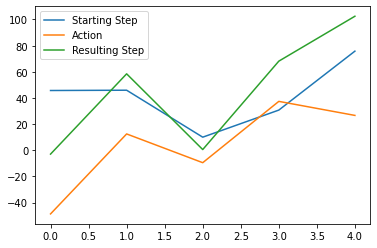

In [ ]:
hot_air_ballon_start_states=torch.rand((5,1))*100
hot_air_ballon_start_actions=torch.rand((5,1))-0.5
hot_air_ballon_next_states=hot_air_ballon_start_states+hot_air_ballon_start_actions*100

plt.plot(hot_air_ballon_start_states.numpy(),label='Starting Step')
plt.plot(hot_air_ballon_start_actions.numpy()*100,label='Action')
plt.plot(hot_air_ballon_next_states.numpy(),label='Resulting Step')
plt.legend()
plt.show()

These are much bigger values... Training a model on these without normalzing can be very hard. 
The worst part is that in order to normalize something like states,
you would need to know *what is the absolute minimum and maximum this state will ever be*. This is a general problem in RL because when the agent is first
starting the states might start small, such as being newer the origin 0,0, but everntually as the agent gets better it starts to get to states like -20,100.
Our model needs to convert these into nice [0,1] or [-1,1] values.

So first, lets see if we can even learn anything without batch norm...

In [ ]:
skill_dyn=SkillDynamics(1,1,2,fix_variance=False,use_batch_norm=False)
opt=Adam(skill_dyn.parameters(),lr=3e-4)
'Prediction:',\
skill_dyn.predict_state(hot_air_ballon_start_states,hot_air_ballon_start_actions),\
'Actual',\
hot_air_ballon_next_states

('Prediction:',
 tensor([[43.4535],
         [43.6629],
         [ 9.4961],
         [29.2001],
         [72.0843]], grad_fn=<AddBackward0>),
 'Actual',
 tensor([[ -2.8968],
         [ 58.4662],
         [  0.5869],
         [ 68.1590],
         [102.4890]]))

In [ ]:
train(300,50)

tensor(5003.8320, grad_fn=<NegBackward>) tensor(0.2850, grad_fn=<MeanBackward0>)
tensor(12.0101, grad_fn=<NegBackward>) tensor(0.2850, grad_fn=<MeanBackward0>)
tensor(11.0967, grad_fn=<NegBackward>) tensor(0.2850, grad_fn=<MeanBackward0>)
tensor(10.1336, grad_fn=<NegBackward>) tensor(0.2850, grad_fn=<MeanBackward0>)
tensor(9.3372, grad_fn=<NegBackward>) tensor(0.2850, grad_fn=<MeanBackward0>)
tensor(8.7437, grad_fn=<NegBackward>) tensor(0.2850, grad_fn=<MeanBackward0>)


In [ ]:
'Prediction:',\
skill_dyn.predict_state(hot_air_ballon_start_states,hot_air_ballon_start_actions),\
'Actual',\
hot_air_ballon_next_states

('Prediction:',
 tensor([[ 62.1747],
         [ 62.4905],
         [ 13.6204],
         [ 41.8130],
         [103.1418]], grad_fn=<AddBackward0>),
 'Actual',
 tensor([[ -2.8968],
         [ 58.4662],
         [  0.5869],
         [ 68.1590],
         [102.4890]]))

Hm... It's diffinitely not amazing. The worst part is that this will likely be made worst with larger and differing batches. Lets see if using batch norm makes this better...

In [ ]:
skill_dyn=SkillDynamics(1,1,2,fix_variance=False,use_batch_norm=True)
opt=Adam(skill_dyn.parameters(),lr=3e-4)
'Prediction:',\
skill_dyn.predict_state(hot_air_ballon_start_states,hot_air_ballon_start_actions),\
'Actual',\
hot_air_ballon_next_states

('Prediction:',
 tensor([[50.2478],
         [50.4456],
         [11.1089],
         [33.7702],
         [83.1706]], grad_fn=<AddBackward0>),
 'Actual',
 tensor([[ -2.8968],
         [ 58.4662],
         [  0.5869],
         [ 68.1590],
         [102.4890]]))

In [ ]:
train(300,50)

tensor(1.5489, grad_fn=<NegBackward>) tensor(0.2850, grad_fn=<MeanBackward0>)
tensor(-0.2800, grad_fn=<NegBackward>) tensor(0.2850, grad_fn=<MeanBackward0>)
tensor(-0.2850, grad_fn=<NegBackward>) tensor(0.2850, grad_fn=<MeanBackward0>)
tensor(-0.2850, grad_fn=<NegBackward>) tensor(0.2850, grad_fn=<MeanBackward0>)
tensor(-0.2850, grad_fn=<NegBackward>) tensor(0.2850, grad_fn=<MeanBackward0>)
tensor(-0.2850, grad_fn=<NegBackward>) tensor(0.2850, grad_fn=<MeanBackward0>)


In [ ]:
'Prediction:',\
skill_dyn.predict_state(hot_air_ballon_start_states,hot_air_ballon_start_actions),\
'Actual',\
hot_air_ballon_next_states

('Prediction:',
 tensor([[ -8.5025],
         [ 59.4843],
         [ -0.7764],
         [ 71.8733],
         [105.0412]], grad_fn=<AddBackward0>),
 'Actual',
 tensor([[ -2.8968],
         [ 58.4662],
         [  0.5869],
         [ 68.1590],
         [102.4890]]))

Great! It seems that batch norm makes `SkillDynamics` compatible with state space inputs of varying values 
that will addapt as the agent explores its environment.

## DADS Agent

Some important notes...

Earlier `SkillDynamics` had:
```python
SkillDynamics(s_dim=1,a_dim=1,n_components=2)
```
where `a_dim` was the action dimension. In reality this is the **skill** dimension. You could say that if `a_dim` is being fed raw actions, then `SkillDynamics` should be renamed `ActionDynamics`.

However, you will see in `DADS`, that the `SkillDynamics` is always fed the skills as opposed to the primitive actions.

### Marginalization methods
> Ways of calculating the denominator.

A good reference is [Probability concepts explained: Marginalisation](https://towardsdatascience.com/probability-concepts-explained-marginalisation-2296846344fc). We need to calculate the intrinsic reward whose primary goal is to say:
- Did this skill produce predictable results? If so, let's reward it for doing so!

The actual math from the [Dynamics-Aware Unsupervised Discovery of Skills](https://arxiv.org/abs/1907.01657) for intrinsic reward:

<h5><center>
$r_z(s,a,s')=\log{\frac{q_{\phi}(s' \mid s,z)}{\sum_{i=1}^L q_{\phi}(s' \mid s,z_i)}}+\log{L},~~ z_i \sim p(z)$
</center></h5>

The first part of getting the intrinsic reward is getting the denominator:
$\sum_{i=1}^L q_{\phi}(s' \mid s,z_i)$ which is going to be the *all other possible skills*.

In [ ]:
# export
def discrete_uniform(current_skill,latent_sz:int=2,alt_s:Tensor=None,deterministic:bool=False):
    "Returns a uniform discrete distribution."
    if deterministic: 
        return torch.cat([torch.roll(current_skill,i,dims=1) for i in range(1,alt_s.shape[0])])
    return Multinomial(1,probs=Tensor([1./latent_sz]*latent_sz)).sample_n(alt_s.shape[0])

In [ ]:
skill_size=5 # Skill 
alt_s=torch.ones((5,3))
current_skill=Tensor([[0,0,0,1,0]])

We have the current skill that was used...

In [ ]:
current_skill

tensor([[0., 0., 0., 1., 0.]])

...and so the other skills to compare it with are...

In [ ]:
discrete_uniform(current_skill,latent_sz=skill_size,alt_s=alt_s,deterministic=True)

tensor([[0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.]])

... but this isn't very random is it? It just rolling them so let's add some random
alternative skills to look at...

In [ ]:
discrete_uniform(current_skill,latent_sz=skill_size,alt_s=alt_s)

/opt/conda/envs/fastrl/lib/python3.7/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


tensor([[0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.]])

But you may ask, what if the skill is continuous? For example:

In [ ]:
current_skill=Tensor([[0.1,0.2,0.2,0.3,0.2]]);current_skill

tensor([[0.1000, 0.2000, 0.2000, 0.3000, 0.2000]])

Well then we have a few other disributions to sample instead!

In [ ]:
# hide
def show2d(t:Tensor): 
    plt.imshow(t.numpy(), cmap='hot', interpolation='nearest')
    plt.show()
#     plt.colorbar()

In [ ]:
# export
def cont_gaussian(sz:int,alt_s:Tensor):
    "Returns a continuous guassian distribution of size `sz`"
    return MultivariateNormal(torch.zeros(sz),torch.eye(sz)).sample_n(alt_s.shape[0])

In [ ]:
cont_gaussian(skill_size,alt_s)

tensor([[-0.8993,  0.8411, -1.3920, -1.3856, -0.4493],
        [-0.3804,  0.4599,  1.8147, -1.1779, -0.5150],
        [ 2.4599, -1.0070, -0.5137, -0.5224, -1.1733],
        [-1.0389,  0.3686,  1.5772, -1.1345, -0.3982],
        [-0.9570,  0.6416,  0.9712,  1.5836, -2.3628]])

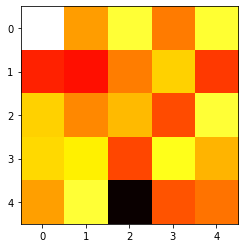

In [ ]:
show2d(cont_gaussian(skill_size,alt_s))

In [ ]:
# export
def cont_uniform(sz,alt_s:Tensor,low=-1.0, high=1.0):
    return torch.zeros((alt_s.shape[0],sz)).uniform_(low,high)

In [ ]:
cont_uniform(skill_size,alt_s,-1,1)

tensor([[ 0.1931, -0.6300,  0.1852, -0.8393, -0.6247],
        [-0.2492, -0.0581,  0.0997,  0.7833, -0.7303],
        [-0.5231, -0.9337,  0.4834,  0.6524,  0.1891],
        [-0.9139, -0.5005, -0.0554, -0.7323,  0.4625],
        [ 0.4625, -0.5545,  0.6470,  0.2621,  0.5467]])

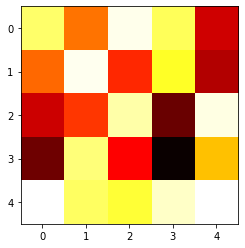

In [ ]:
show2d(cont_uniform(skill_size,alt_s,-1,1))

### Agent

In [ ]:
# export
@delegates(SAC)
class DADS(SAC):
    def __init__(self,num_inputs,action_space,num_skills:int=20,include_actions:bool=False,hidden_size=100,lr=0.003,
                 n_components:int=4,prior_samples:int=100,latent_sz:int=2,latent_prior_method='',
                 skill_lr=3e-4,episide_horizon:int=1,planning_horizon:int=1,
                 primitive_horizon:int=1,train_dyn=True,**kwargs):
        store_attr()
        self.num_inputs=num_inputs+self.num_skills
        self.original_num_inputs=num_inputs
        self.skill_dyn=SkillDynamics(self.original_num_inputs,self.num_skills,self.n_components)
        super().__init__(self.num_inputs,self.action_space,hidden_size=hidden_size,lr=lr,**kwargs)
        self.skill_opt=Adam(self.skill_dyn.parameters(),lr=3e-4)
        
        self.p_z=np.full(self.num_skills,1.0/self.num_skills)
        self.log_p_z_episode=[]
        self.z=0
        self.reset_z()
    
    @torch.no_grad()
    def intrinsic_reward(self,s,skill:Tensor,sp,gpu_limit=20*4000):
        "Given a batch of `s` and `sp` what is the reward for using skill `z`?"
        n_repetitions=self.prior_samples if self.prior_samples>0 else self.num_skills-1
        alt_s=torch.cat([s]*n_repetitions,axis=0)
        alt_sp=torch.cat([sp]*n_repetitions,axis=0)
        
        if self.latent_prior_method=='discrete_uniform' and not self.prior_samples: 
            alt_skill=discrete_uniform(skill,self.num_skills,alt_s,True)
        elif self.latent_prior_method=='discrete_uniform':
            alt_skill=discrete_uniform(skill,self.num_skills,alt_s,False)
        elif self.latent_prior_method=='cont_gaussian':
            alt_skill=cont_gaussian(self.num_skills,alt_s)
        else:
            alt_skill=cont_uniform(self.num_skills,alt_s)
            
        logp=self.skill_dyn.log_prob(s,skill,sp)
        
        if alt_s.shape[0]<=gpu_limit:
            logp_altz=self.skill_dyn.log_prob(alt_s,alt_skill,alt_sp)
        else:
            # TODO JL: Does this chunking code have to be so complex? Does fastcore have something
            logp_altz=[]
            for idx in range(alt_s.shape[0]//gpu_limit):
                start_idx=idx*gpu_limit
                end_idx=(idx+1)*gpu_limit
                logp_altz.append(
                    self.skill_dyn.log_prob(alt_s[start_idx:end_idx],
                                            alt_skill[start_idx:end_idx],
                                            alt_sp[start_idx:end_idx])
                )
            # TODO: JL: ok what is the scenario where this if statement is needed?
            if alt_s.shape[0]%gpu_limit:
                start_idx=alt_s.shape[0]%gpu_limit
                logp_altz.append(  
                    self.skill_dyn.log_prob(alt_s[-start_idx:],
                                            alt_skill[-start_idx:],
                                            alt_sp[-start_idx:]))
            logp_altz=torch.cat(logp_altz)
        logp_altz=torch.stack(torch.chunk(logp_altz,n_repetitions))

        intrinsic_reward=np.log(n_repetitions+1)-torch.log(
            1+torch.exp(torch.clamp(logp_altz-logp.reshape(1,-1),-50,50)).sum(dim=0)
        )

        return intrinsic_reward.reshape(-1,1),logp,logp_altz
    
    # TODO: They have batch weighting here. Maybe look into
    def increase_skill_opt(self,log_prob:Tensor):
        self.skill_opt.zero_grad()
        loss=-torch.mean(log_prob)
        loss.backward()
        self.skill_opt.step()
        
    def decrease_skill_opt(self,log_prob:Tensor):
        self.skill_opt.zero_grad()
        loss=torch.mean(log_prob)
        loss.backward()
        self.skill_opt.step()
        
    def sample_z(self):
        """Samples z from p(z), using probabilities in self._p_z."""
        return np.random.choice(self.num_skills,p=self.p_z)
    
    def reset_z(self): self.z=self.sample_z()
    def __call__(self,s,asl):
        aug_s=self.concat_obs_z(s,self.z)
        return super().__call__(aug_s,asl)
    
    def concat_obs_z(self,obs,z):
        """Concatenates the observation to a one-hot encoding of Z."""
        assert np.isscalar(z)
        if type(obs)==list and len(obs)==1: obs=obs[0]
        if len(obs.shape)==2 and obs.shape[0]==1: obs=obs[0]
            
        z_one_hot=np.zeros(self.num_skills)
        z_one_hot[z]=1
        if type(obs)==Tensor: obs=obs.cpu()
        return torch.FloatTensor(np.hstack([obs,z_one_hot])).reshape(1,-1)
    
    def update_parameters(self, *yb, learn):
        batch=learn.sample_yb

        state_batch=torch.stack([o.state.to(device=default_device()) for o in batch]).float()
        next_state_batch=torch.stack([o.last_state.to(device=default_device()) for o in batch]).float()
        action_batch=torch.stack([o.action.to(device=default_device()) for o in batch]).float()
        reward_batch=torch.stack([o.reward.to(device=default_device()) for o in batch]).float()
        mask_batch=torch.stack([o.done.to(device=default_device()) for o in batch]).float().unsqueeze(1)
        
        if self.train_dyn:
            self.increase_skill_opt(self.skill_dyn.log_prob(
                state_batch[:,:self.num_skills],
                state_batch[:,self.num_skills:],
                next_state_batch[:,:self.num_skills]
            ))
            
            reward_batch,_,_=self.intrinsic_reward(                
                state_batch[:,:self.num_skills],
                state_batch[:,self.num_skills:],
                next_state_batch[:,:self.num_skills])
#             print(reward_batch)
            
        
        with torch.no_grad():
            next_state_action, next_state_log_pi, _ = self.policy.sample(next_state_batch)
            qf1_next_target, qf2_next_target = self.critic_target(next_state_batch, next_state_action)
            min_qf_next_target = torch.min(qf1_next_target, qf2_next_target) - self.alpha * next_state_log_pi
            next_q_value = reward_batch + (1-mask_batch) * self.gamma * (min_qf_next_target)
        qf1, qf2 = self.critic(state_batch, action_batch)  # Two Q-functions to mitigate positive bias in the policy improvement step
        qf1_loss = F.mse_loss(qf1, next_q_value)  # JQ = 𝔼(st,at)~D[0.5(Q1(st,at) - r(st,at) - γ(𝔼st+1~p[V(st+1)]))^2]
        qf2_loss = F.mse_loss(qf2, next_q_value)  # JQ = 𝔼(st,at)~D[0.5(Q1(st,at) - r(st,at) - γ(𝔼st+1~p[V(st+1)]))^2]
        qf_loss = qf1_loss + qf2_loss

        self.critic_optim.zero_grad()
        qf_loss.backward()
        self.critic_optim.step()

        pi, log_pi, _ = self.policy.sample(state_batch)

        qf1_pi, qf2_pi = self.critic(state_batch, pi)
        min_qf_pi = torch.min(qf1_pi, qf2_pi)

        policy_loss = ((self.alpha * log_pi) - min_qf_pi).mean() # Jπ = 𝔼st∼D,εt∼N[α * logπ(f(εt;st)|st) − Q(st,f(εt;st))]

        self.policy_optim.zero_grad()
        policy_loss.backward()
        self.policy_optim.step()

        if self.automatic_entropy_tuning:
            alpha_loss = -(self.log_alpha * (log_pi + self.target_entropy).detach()).mean()

            self.alpha_optim.zero_grad()
            alpha_loss.backward()
            self.alpha_optim.step()

            self.alpha = self.log_alpha.exp()
            alpha_tlogs = self.alpha.clone() # For TensorboardX logs
        else:
            alpha_loss = torch.tensor(0.).to(self.device)
            alpha_tlogs = torch.tensor(self.alpha) # For TensorboardX logs


        if self.updates % self.target_update_interval == 0:
            soft_update(self.critic_target, self.critic, self.tau)
        self.updates+=1
#         print(self.updates)
#         print('complete')
        return qf1_loss+ qf2_loss+ policy_loss+ alpha_loss+ alpha_tlogs

In [ ]:
dads=DADS(1,gym.spaces.Box(-1,1,(1,)),2);dads

DADS(model=None)

In [ ]:
intrinsic_reward,_,_=dads.intrinsic_reward(hot_air_ballon_start_states,
                      Tensor([[0,1]]*5),
                      hot_air_ballon_next_states);intrinsic_reward

tensor([[-0.3687],
        [ 0.0740],
        [-0.6713],
        [-2.2072],
        [ 0.0245]])

Now, the `DADS.__call__` function, unlike other agents, has a planning behavior. We want to test that as it learns,
the planners get better at estimating the future states its going to be in.

For now, we will be using dicrete skills until we refactor. The continuous implimentation is [MPPI (Williams et al., 2016)](https://www.cc.gatech.edu/~bboots3/files/InformationTheoreticMPC.pdf) and is used by DADS for continuous actions for the goal of making sure they have smooth transitions.

> Warning: The orignal implimentation, the planning section gets the predicted states for all of the skill. How does it decide which state to go with? 
Well... It uses (probably) straight line distance to the goal state... This means that the planner in DADS will **only work with environments with linear dense goals**.
Because of this, instead we have an implimentation that simply looks ahead given a constant goal.

Below is a non-working example of the planner. This requires the env to have a goal that can be recalculated:
```python
class Planner(object):
    def __init__(self,init_s,agent:DADS,env,episide_horizon:int=1,planning_horizon:int=1,
                 primitive_horizon:int=10):
        store_attr()
    
    def __next__(self):
        init_skills=torch.eye(self.agent.num_skills)
        s=copy(self.init_s)
        for _ in range(self.episide_horizon//self.primitive_horizon):
            running_s=Tensor([s]*agent.num_skills)
            computed_reward=0
            for _ in range(self.planning_horizon):
                pred_s=self.agent.skill_dny.predict_state(running_s[:,:self.num_skills],
                                                          init_skills)
                computed_reward+=env.compute_reward(running_s[:,:self.num_skills],
                                                    pred_s)
                
            agent.z=torch.argmax(computed_reward)
            s=agent.concat_obs_z(s,agent.z)
            yield s
```
Once we add a Meta Learner, we can replace the `computed_reward+=env.compute_reward` with something like a `DDQN` so that `DADS` can perform in-operation
skill switching. 

In [ ]:
import gym
from pybulletgym.envs import *
from IPython import display
import PIL.Image
%matplotlib inline

env=gym.make('InvertedPendulumPyBulletEnv-v0')
s=env.reset()

dads=DADS(1,gym.spaces.Box(-1,1,(1,)),2);dads

planner=Planner(s,dads)

for _ in range(200):
    display.clear_output(wait=True)
    display.display(PIL.Image.fromarray(env.render(mode='rgb_array')))

#     agent.z=z
#     a,_=agent(s,None)

    s,r,d,_=env.step(a)
    if d:
        break

## Full Training

In [ ]:
# export
class ExperienceReplay(Callback):
    def __init__(self,sz=100,bs=128,starting_els=1,max_steps=1):
        store_attr()
        self.queue=deque(maxlen=int(sz))
        self.max_steps=max_steps
        
    def before_fit(self):
        self.learn.agent.warming_up=True
        while len(self.queue)<self.starting_els:
            for i,o in enumerate(self.dls.train):
                batch=[ExperienceFirstLast(state=o[0][i],action=o[1][i],reward=o[2][i],
                                    last_state=o[3][i], done=(o[4][i] and self.max_steps!=o[6][i]),episode_reward=o[5][i],steps=o[6][i])
                                    for i in range(len(o[0]))]
#                 print(self.max_steps,max([o.steps for o in batch]))
                for _b in batch: self.queue.append(_b)
                if len(self.queue)>self.starting_els:break
        self.learn.agent.warming_up=False

#     def after_epoch(self):
#         print(len(self.queue))
    def before_batch(self):
#         print(len(self.queue))
        b=list(self.learn.xb)+list(self.learn.yb)
        batch=[ExperienceFirstLast(state=b[0][i],action=b[1][i],reward=b[2][i],
                                last_state=b[3][i], done=(b[4][i] and self.max_steps!=b[6][i]),episode_reward=b[5][i],
                                steps=b[6][i])
                                for i in range(len(b[0]))]
        for _b in batch: self.queue.append(_b)
        idxs=np.random.randint(0,len(self.queue), self.bs)
        self.learn.sample_yb=[self.queue[i] for i in idxs]

In [ ]:
# export
class SACCriticTrainer(Callback):
    def after_batch(self): 
        self.learn.dls.bs=1
        for d in self.learn.dls.loaders: d.bs=1
        
    def after_loss(self):raise CancelBatchException

In [ ]:
# export
class DADSTrainer(ExperienceReplay):

    def __init__(self,*args,**kwargs):
        self.log_p_z_episode=[]
        super().__init__(*args,**kwargs)
        
    def before_fit(self):
        self.learn.agent.warming_up=True
        while len(self.queue)<self.starting_els:
            for i,o in enumerate(self.dls.train):
                z=self.learn.agent.z
                batch=[ExperienceFirstLast(state=self.learn.agent.concat_obs_z(o[0][i],z)[0],
                                           action=o[1][i],
                                           reward=o[2][i],
                                           last_state=self.learn.agent.concat_obs_z(o[3][i],z)[0], 
                                           done=(o[4][i] and self.max_steps!=o[6][i]),
                                           episode_reward=o[5][i],steps=o[6][i])
                                    for i in range(len(o[0]))]
#                 print(self.max_steps,max([o.steps for o in batch]))
#                 print(batch[0])
#                 for k in range(len(batch)):
#                     intrinsic_reward,disc_out=self.learn.agent.intrinsic_reward(Tensor(batch[k].last_state))
#                     self.learn.agent.increase_skill_opt(self.agent.z,disc_out)
#                     batch[k]=ExperienceFirstLast(
#                         state=batch[k].state.to(device=default_device()),
#                         action=batch[k].action,
#                         reward=batch[k].reward,
#                         last_state=batch[k].last_state.to(device=default_device()),
#                         done=batch[k].done,
#                         episode_reward=batch[k].episode_reward,
#                         steps=batch[k].steps
#                     )


#                 print(batch[0])
                for _b in batch:self.queue.append(_b)
                if any([_b.done for _b in batch]): self.learn.agent.reset_z()
                if len(self.queue)>self.starting_els:break
        self.learn.agent.warming_up=False

# #     def after_epoch(self):
# #         print(len(self.queue))
    def before_batch(self):
#         print(len(self.queue))
        b=list(self.learn.xb)+list(self.learn.yb)
        z=self.learn.agent.z
        batch=[ExperienceFirstLast(state=self.learn.agent.concat_obs_z(b[0][i],z)[0],
                                   action=b[1][i],
                                   reward=b[2][i],
                                   last_state=self.learn.agent.concat_obs_z(b[3][i],z)[0], 
                                   done=(b[4][i] and self.max_steps!=b[6][i]),
                                   episode_reward=b[5][i],steps=b[6][i])
              for i in range(len(b[0]))]
        
#         for k in range(len(batch)):
#             intrinsic_reward,disc_out=self.learn.agent.intrinsic_reward(Tensor(batch[k].last_state))
#             self.learn.agent.discriminator_learn(self.agent.z,disc_out)
#             batch[k]=ExperienceFirstLast(
#                 state=batch[k].state.to(device=default_device()),
#                 action=batch[k].action,
#                 reward=intrinsic_reward,
#                 last_state=batch[k].last_state.to(device=default_device()),
#                 done=batch[k].done,
#                 episode_reward=batch[k].episode_reward,
#                 steps=batch[k].steps
#             )
        
#         print(self.learn.xb)
        self.learn.xb=(torch.stack([e.state for e in batch]),)
#         print(self.learn.yb)
        self.learn.yb=(torch.stack([o.action for o in batch]),
                       torch.stack([o.reward for o in batch]),
                       torch.stack([o.last_state for o in batch]),
                       torch.stack([o.done for o in batch]),
                       torch.stack([o.episode_reward for o in batch]),
                       torch.stack([o.steps for o in batch]))
#         print(self.learn.yb)
        
        for _b in batch: self.queue.append(_b)
        idxs=np.random.randint(0,len(self.queue), self.bs)
        self.learn.sample_yb=[self.queue[i] for i in idxs]

In [ ]:
from pybulletgym.envs import *

env='InvertedPendulumPyBulletEnv-v0'
agent=DADS(5,gym.make(env).action_space,gamma=0.99,tau=0.005,alpha=0.1,hidden_size=300,num_skills=5)
block=FirstLastExperienceBlock(agent=agent,seed=0,n_steps=2,exclude_nones=True,
                               dls_kwargs={'bs':1,'num_workers':0,'verbose':False,'indexed':True,'shuffle_train':False})
blk=IterableDataBlock(blocks=(block),splitter=FuncSplitter(lambda x:False))
dls=blk.dataloaders([env]*1,n=1000,device=default_device())

learner=SACLearner(dls,agent=agent,cbs=[DADSTrainer(sz=1000000,bs=64,starting_els=1000,max_steps=gym.make(env)._max_episode_steps),
                                        SACCriticTrainer],
                   metrics=[AvgEpisodeRewardMetric(experience_cls=ExperienceFirstLast)])
learner.fit(10,lr=0.003,wd=0)

epoch,train_loss,train_avg_episode_r,valid_loss,valid_avg_episode_r,time
0,-3.924977,26.916667,None,26.916667,00:28
1,-3.294553,41.511628,None,41.511628,00:30
2,-2.442293,52.387755,None,52.387755,00:31
3,-2.159690,61.200000,None,61.200000,00:31
4,-2.214790,68.483871,None,68.483871,00:30
5,-2.215024,74.260870,None,74.260870,00:31
6,-2.351509,78.680000,None,78.680000,00:31
7,-2.919187,83.320988,None,83.320988,00:32
8,-2.729967,87.372093,None,87.372093,00:32
9,-2.266962,91.666667,None,91.666667,00:32


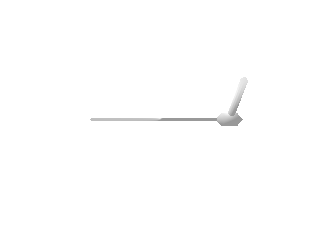

In [ ]:
# hide
# slow
import gym
from IPython import display
import PIL.Image
%matplotlib inline

env=gym.make('InvertedPendulumPyBulletEnv-v0')
s=env.reset()

for z in range(5):
    for i in range(0,100,20):
        s=env.reset()
        env.seed(i)
        for _ in range(200):
            display.clear_output(wait=True)
            display.display(PIL.Image.fromarray(env.render(mode='rgb_array')))

            agent.z=z
            a,_=agent(s,None)

            s,r,d,_=env.step(a)
            if d:
                break

In [ ]:
# hide
from nbdev.export import *
from nbdev.export2html import *
notebook2script()
notebook2html()

Converted 00_core.ipynb.
Converted 01_wrappers.ipynb.
Converted 03_basic_agents.ipynb.
Converted 04_learner.ipynb.
Converted 05a_ptan_extend.ipynb.
Converted 05b_data.ipynb.
Converted 05c_async_data.ipynb.
Converted 13_metrics.ipynb.
Converted 14a_actorcritic.sac.ipynb.
Converted 14b_actorcritic.diayn.ipynb.
Converted 14c_actorcritic.dads.ipynb.
Converted 15_actorcritic.a3c_data.ipynb.
Converted 16_actorcritic.a2c.ipynb.
Converted 18_policy_gradient.ppo.ipynb.
Converted 19_policy_gradient.trpo.ipynb.
Converted 20a_qlearning.dqn.ipynb.
Converted 20b_qlearning.dqn_n_step.ipynb.
Converted 20c_qlearning.dqn_target.ipynb.
Converted 20d_qlearning.dqn_double.ipynb.
Converted 20e_qlearning.dqn_noisy.ipynb.
Converted index.ipynb.
Converted notes.ipynb.
converting: /opt/project/fastrl/nbs/14c_actorcritic.dads.ipynb
